# Load Data

In [74]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds

import numpy as np
import matplotlib.pyplot as plt

In [75]:
# print version of tensorflow and tfds
print("Tensorflow version is {}".format( tf.__version__))
print("Tensorflow datasets version is {}".format(tfds.__version__))

Tensorflow version is 2.17.0
Tensorflow datasets version is 4.9.6


To load data set we have two ways 

first is 

(train_data,train_label), (test_data,test_label) = keras.datasets.cifar10.load_data()

Secound is

In [76]:
(train_data,val_data,test_data), info = tfds.load('cifar10',
                                                    split=['train','test[:80%]','test[80%:]'],
                                                    as_supervised=True,
                                                    shuffle_files=False,
                                                    with_info=True
                                                    )

Visual Breakdown:

Training Data (train_data):

Contains 50,000 images from the original training set.

Validation Data (val_data):

Contains the first 5,000 images from the original test set.

Test Data (test_data):

Contains the remaining 5,000 images from the original test set.

In [77]:
#print counts of train, val and test data
print("Train data count is {}".format(len(list(train_data))))
print("Validation data count is {}".format(len(list(val_data))))
print("Test data count is {}".format(len(list(test_data))))

Train data count is 50000
Validation data count is 8000
Test data count is 2000


In [78]:
info.features['label'].num_classes

10

In [79]:
info.features['label'].names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

# Look into images

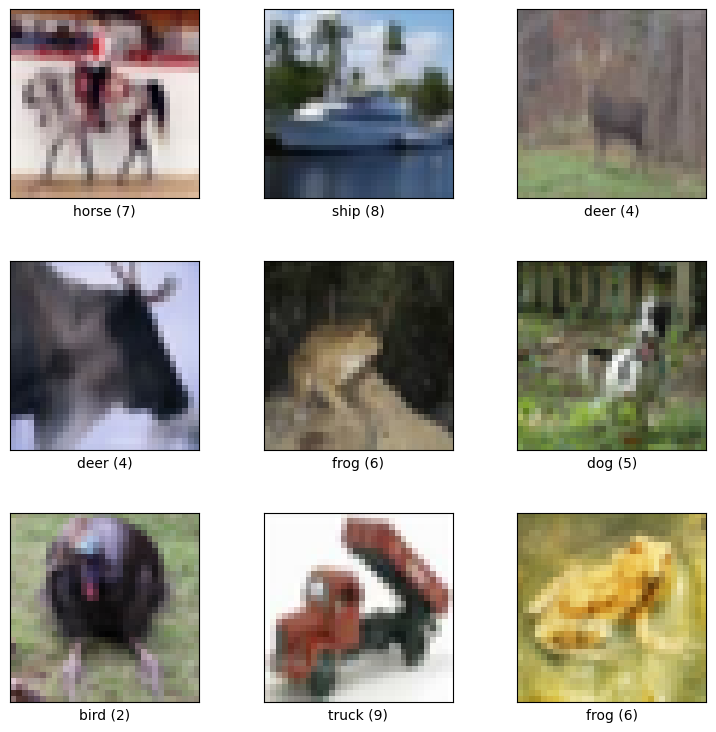

In [80]:
fig = tfds.show_examples(train_data, info)

# Prepare data : Building and Training pipeline

In [81]:
def preprocess(image,label):
    '''
    Function to convert image to float32  
    '''
    normalized_image = tf.cast(image, tf.float32) / 255.0
    
    return normalized_image, label

In [82]:
def train_data_prep(data,shuffle_size,batch_size):
    '''
    Function to prepare train data
    '''
    data = data.map(preprocess)
    data = data.cache() #cleat memory for next batch
    data = data.shuffle(shuffle_size).repeat() #Repeat to avoid overfitting
    data = data.batch(batch_size)
    data = data.prefetch(tf.data.experimental.AUTOTUNE)

    return data

In [83]:
def test_data_prep(data,batch_size):
    '''
    Function to prepare test data
    '''
    data = data.map(preprocess)
    data = data.batch(batch_size)
    data = data.cache()
    data = data.prefetch(tf.data.experimental.AUTOTUNE)

    return data

In [84]:
train_data = train_data_prep(train_data,shuffle_size=1000,batch_size=32)

In [85]:
test_data = test_data_prep(test_data,batch_size=32)

In [86]:
val_data = test_data_prep(val_data,batch_size=32)

# Create Model 

In [87]:
input_shape = [32,32,3]

cifar_cnn = tf.keras.models.Sequential([

    #First Convolutional Layer with 64 filters and 3x3 kernel size
    tf.keras.layers.Conv2D(filters= 64 ,kernel_size=(3,3),activation='relu',input_shape=input_shape),
    # First Maxpooling layer
    tf.keras.layers.MaxPooling2D(pool_size = 2),

    #Second Convolutional Layer
    tf.keras.layers.Conv2D(filters= 128 ,kernel_size=(3,3),activation='relu'),

    #Second Maxpooling layer
    tf.keras.layers.MaxPooling2D(pool_size = 2),

    #third Convolutional Layer
    tf.keras.layers.Conv2D(filters= 256 ,kernel_size=(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size = 2),

    # Flatten layers
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    #Fully connected layer

    tf.keras.layers.Dense(units=128,activation='relu'),
    tf.keras.layers.Dropout(0.5),

    #Output layer
    tf.keras.layers.Dense(units=10,activation='softmax')


])

c:\Users\hazem\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [88]:
# Model summary

cifar_cnn.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 30, 30, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 15, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 13, 13, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 4, 4, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 503,306 (1.92 MB)

 Trainable params: 503,306 (1.92 MB)

 Non-trainable params: 0 (0.00 B)

In [89]:
tf.keras.utils.plot_model(cifar_cnn,show_shapes=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


# Compile model

In [90]:
cifar_cnn.compile(optimizer='nadam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

In [91]:
batch_size = 32
train_size  = info.splits['train'].num_examples

val_size = len(val_data)

train_steps = int(train_size/batch_size)
val_steps = int(val_size/batch_size)

model_history = cifar_cnn.fit(train_data,
                              validation_data=val_data,
                              epochs=9,
                              steps_per_epoch=train_steps,
                              validation_steps=val_steps)


Epoch 1/9
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 54s 33ms/step - accuracy: 0.2899 - loss: 1.8785 - val_accuracy: 0.5134 - val_loss: 1.2546
Epoch 2/9
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 49s 32ms/step - accuracy: 0.5341 - loss: 1.3159 - val_accuracy: 0.6696 - val_loss: 0.9382
Epoch 3/9
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 50s 32ms/step - accuracy: 0.5968 - loss: 1.1536 - val_accuracy: 0.6741 - val_loss: 0.8734
Epoch 4/9
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 46s 30ms/step - accuracy: 0.6292 - loss: 1.0615 - val_accuracy: 0.7455 - val_loss: 0.8194
Epoch 5/9
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 46s 30ms/step - accuracy: 0.6619 - loss: 0.9746 - val_accuracy: 0.6786 - val_loss: 0.9298
Epoch 6/9
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 48s 31ms/step - accuracy: 0.6769 - loss: 0.9397 - val_accuracy: 0.7455 - val_loss: 0.7137
Epoch 7/9
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 49s 31ms/step - accuracy: 0.6893 - loss: 0.8883 - val_accuracy: 0.7455 - val_loss: 0.7273
Epoch 8/9
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 50s 32ms/step - accuracy: 0.7053 - loss: 0

# Plot output

In [93]:
model_history1 = model_history.history

accuracy = model_history1['accuracy']
val_accuracy = model_history1['val_accuracy']
loss = model_history1['loss']
val_loss = model_history1['val_loss']

epochs = model_history.epoch

In [94]:
def plot_acc(acc,val_acc,epochs):
    '''
    Function to plot accuracy
    '''
    plt.figure(figsize=(10,5))
    plt.plot(epochs,acc,label='Training Accuracy')
    plt.plot(epochs,val_acc,label='Validation Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

def plot_loss(loss,val_loss,epochs):
    '''
    Function to plot loss
    '''
    plt.figure(figsize=(10,5))
    plt.plot(epochs,loss,label='Training Loss')
    plt.plot(epochs,val_loss,label='Validation Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    

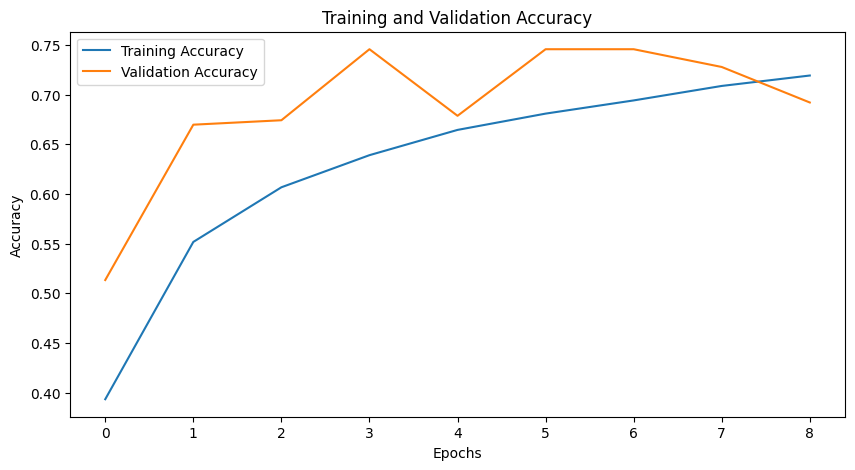

In [95]:
plot_acc(accuracy,val_accuracy,epochs)

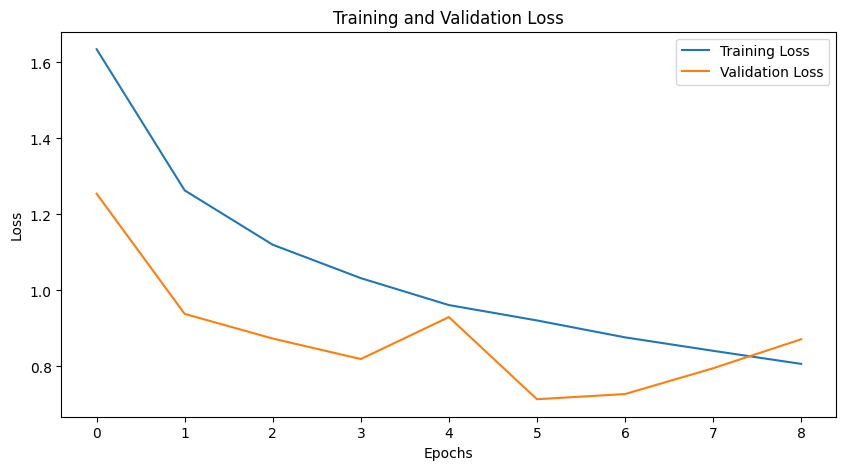

In [96]:
plot_loss(loss,val_loss,epochs)

# Evaluation

In [92]:
test_loss, test_accuracy = cifar_cnn.evaluate(test_data)


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7363 - loss: 0.7440


# Save model

In [97]:
cifar_cnn.save('cifar_cnn.h5')

In [98]:
from tensorflow.keras.models import load_model

model = load_model('cifar_cnn.h5')

In [99]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 30, 30, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 15, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 13, 13, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 4, 4, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 503,309 (1.92 MB)

 Trainable params: 503,306 (1.92 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3 (16.00 B)